Valeur de X initiale: [[1 1]]
Valeur de Y après propagation pour la couche: [[1.  0.5]]
Valeur de Y après propagation pour la couche: [[0.5 0.5]]
dJ_dY pour la couche finale: [[-1.  1.]]
dJ_dW: [[-1.   1. ]
 [-0.5  0.5]]
dJ_dB: [[-1.  1.]]
dJ_dX: [[-0.8  0.2]]
W modifié: [[ 0.8  -0.2 ]
 [ 0.05  0.15]]
B modifié: [[-0.1  0.4]]
dJ_dW: [[-0.8  0.2]
 [-0.8  0.2]]
dJ_dB: [[-0.8  0.2]]
dJ_dX: [[-0.38 -0.3 ]]
W modifié: [[ 0.58  0.08]
 [ 0.38 -0.32]]
B modifié: [[0.28 0.68]]
-------- > epoch 1:  erreur quadratique moyenne 0.5
Valeur de X initiale: [[1 1]]
Valeur de Y après propagation pour la couche: [[1.24 0.44]]
Valeur de Y après propagation pour la couche: [[0.914 0.218]]
dJ_dY pour la couche finale: [[-0.172  0.436]]
dJ_dW: [[-0.21328  0.54064]
 [-0.07568  0.19184]]
dJ_dB: [[-0.172  0.436]]
dJ_dX: [[-0.2248  0.0568]]
W modifié: [[ 0.821328 -0.254064]
 [ 0.057568  0.130816]]
B modifié: [[-0.0828  0.3564]]
dJ_dW: [[-0.2248  0.0568]
 [-0.2248  0.0568]]
dJ_dB: [[-0.2248  0.0568]]
dJ_dX: [[-0.

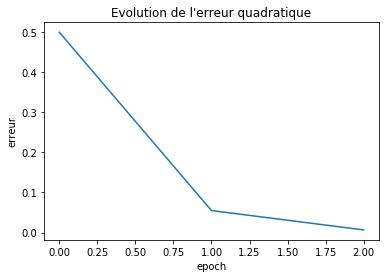

In [1]:
# -*- coding: utf-8 -*-
# Implémentation d'un RNA multi-couche, exemple avec le RNA Minus
%matplotlib inline
import numpy as np
np.random.seed(42) # pour reproduire les mêmes résultats
import matplotlib.pyplot as plt

class CoucheDenseLineaire():
    """ Couche linéaire dense. Y=WX+B
    """
    def __init__(self,n,m,init_W=None,init_B=None):
        """ Initilalise les paramètres de la couche. W et B sont initialisés avec init_W et init_B lorsque spécifiés.
        Sinon, des valeurs aléatoires sont générés pour W une distribution normale N(0,1) et B est initialisée avec des 0 
        si les paramètres init_W et init_B ne sont pas spécifiés.
        n : int, taille du vecteur d'entrée X
        m : int, taille du vecteur de sortie Y
        init_W : np.array, shape(n,m), valeur initiale optionnelle de W
        init_B : np.array, shape(1,m), valeur initial optionnelle de B
        """
        if init_W is None :
            self.W = np.random.randn(n,m) 
        else:
            self.W = init_W
        if init_B is None :
            self.B = np.zeros(1,m)
        else:
            self.B = init_B

    def propager_une_couche(self,X):
        """ Fait la propagation de X et retourne Y=WX+B. 
        """
        self.X = X
        self.Y = self.B + np.dot(self.X,self.W)
        return self.Y

    def retropropager_une_couche(self,dJ_dY,taux,trace=False):
        """ Calculer les dérivées dJ_dW,dJ_dB,dJ_dX pour une couche dense linéaire et
        mettre à jour les paramètres selon le taux spécifié
        
        dJ_dY : np.array(1,2), dérivées de J par rapport à la sortie Y
        taux : float, le taux dans la descente de gradiant
        retourne la dérivée de J par rapport à X
        """
        dJ_dW = np.dot(self.X.T,dJ_dY)
        dJ_dB = dJ_dY
        dJ_dX = np.dot(dJ_dY,self.W.T)
        if trace:
            print("dJ_dW:",dJ_dW)
            print("dJ_dB:",dJ_dB)
            print("dJ_dX:",dJ_dX)
        # Metre à jour les paramètres W et B
        self.W -= taux * dJ_dW
        self.B -= taux * dJ_dB
        if trace:
            print("W modifié:",self.W)
            print("B modifié:",self.B)
        return dJ_dX
    
def erreur_quadratique(y_prediction,y):
    """ Retourne l'erreur quadratique entre la prédiction y_prediction et la valeur attendue y
    """ 
    return np.sum(np.power(y_prediction-y,2))

def d_erreur_quadratique(y_prediction,y):
    return 2*(y_prediction-y)

class ReseauMultiCouches:
    """ Réseau mutli-couche formé par une séquence de Couches
    
    couches : liste de Couches du RNA
    cout : fonction qui calcule de cout J
    derivee_cout: dérivée de la fonction de cout
    """
    def __init__(self):
        self.couches = []
        self.cout = None
        self.derivee_cout = None

    def ajouter_couche(self,couche):
        self.couches.append(couche)

    def specifier_J(self,cout,derivee_cout):
        """ Spécifier la fonction de coût J et sa dérivée
        """
        self.cout = cout
        self.derivee_cout = derivee_cout

    def propagation_donnees_ent_X(self,donnees_ent_X,trace=False):
        """ Prédire Y pour chacune des observations dans donnees_ent_X)
        donnees_ent_X : np.array 3D des valeurs de X pour chacune des observations
            chacun des X est un np.array 2D de taille (1,n)
        """

        nb_observations = len(donnees_ent_X)
        predictions_Y = []
        for indice_observation in range(nb_observations):
            XY_propage = donnees_ent_X[indice_observation]
            if trace: 
                print("Valeur de X initiale:",XY_propage)
            for couche in self.couches:
                XY_propage = couche.propager_une_couche(XY_propage)
                if trace: 
                    print("Valeur de Y après propagation pour la couche:",XY_propage)
            predictions_Y.append(XY_propage)

        return predictions_Y

    def entrainer_descente_gradiant_stochastique(self,donnees_ent_X,donnees_ent_Y,nb_epochs,taux,trace=False):
        """ Entrainer le réseau par descente de gradiant stochastique (une observation à la fois)
        
        donnees_ent_X : np.array 3D des valeurs de X pour chacune des observations
            chacun des X est un np.array 2D de taille (1,n)
        donnees_ent_Y : np.array 3D des valeurs de Y pour chacune des observations
            chacun des Y est un np.array 2D de taille (1,m)
        """
        
        nb_observations = len(donnees_ent_X)
        if trace :
            liste_eq = []

        # Boucle d'entrainement principale, nb_epochs fois
        for cycle in range(nb_epochs):
            cout_total = 0
            # Descente de gradiant stochastique, une observation à la fois
            for indice_observation in range(nb_observations):
                # Propagation avant pour une observation X
                # XY_propage : contient la valeur de X de la couche courante qui correspond 
                # à la valeur de Y de la couche précédente
                XY_propage = donnees_ent_X[indice_observation]
                if trace: 
                    print("Valeur de X initiale:",XY_propage)

                for couche in self.couches:
                    XY_propage = couche.propager_une_couche(XY_propage)
                    if trace: 
                        print("Valeur de Y après propagation pour la couche:",XY_propage)

                # Calcul du coût pour une observation
                cout_total += self.cout(XY_propage,donnees_ent_Y[indice_observation])

                # Rétropropagation pour une observation
                # dJ_dX_dJ_dY représente la valeur de la dérivée dJ_dX de la couche suivante
                # qui correspond à dJ_dY de la couche en cours de traitement
                dJ_dX_dJ_dY = self.derivee_cout(XY_propage,donnees_ent_Y[indice_observation])
                if trace :
                    print("dJ_dY pour la couche finale:",dJ_dX_dJ_dY)
                for couche in reversed(self.couches):
                    dJ_dX_dJ_dY = couche.retropropager_une_couche(dJ_dX_dJ_dY,taux,trace)

            # Calculer et afficher le coût moyen pour une epoch
            cout_moyen = cout_total/nb_observations
            if trace:
                print(f'-------- > epoch {cycle+1}:  erreur quadratique moyenne {cout_moyen}')
                liste_eq.append(cout_moyen)
        # Affichage du graphique d'évolution de l'erreur quadratique
        if trace:
            plt.plot(np.arange(0,nb_epochs),liste_eq)
            plt.title("Evolution de l'erreur quadratique")
            plt.xlabel('epoch')
            plt.ylabel('erreur')
            plt.legend(loc='upper center')
            plt.show()


# Une seule observation pour illustrer le fonctionnement de RNA Minus           
donnees_ent_X = np.array([[[1,1]]])
donnees_ent_Y = np.array([[[1,0]]])

# Définir les paramètres initiaux de RNA Minus
B1=np.array([[0.2,0.7]])
W1=np.array([[0.5,0.1],[0.3,-0.3]])
B2=np.array([[-0.2,0.5]])
W2=np.array([[0.7,-0.1],[0,0.2]])

# Définir l'architecture du RNA Minus
un_RNA = ReseauMultiCouches()
un_RNA.specifier_J(erreur_quadratique,d_erreur_quadratique)
un_RNA.ajouter_couche(CoucheDenseLineaire(2,2,init_W=W1,init_B=B1))
un_RNA.ajouter_couche(CoucheDenseLineaire(2,2,init_W=W2,init_B=B2))

# Entrainer le RNA Minus
un_RNA.entrainer_descente_gradiant_stochastique(donnees_ent_X,donnees_ent_Y,nb_epochs=3,taux=0.1,trace=True)